In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split
import random
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [45]:
# --- Constants ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 512
NUM_WORKERS = 0
TRAIN_RATIO = 0.95
VAL_RATIO = 0.05

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# --- Directories ---
art_dir = "data/pacs_data/pacs_data/art_painting"
cartoon_dir = "data/pacs_data/pacs_data/cartoon"
photo_dir = "data/pacs_data/pacs_data/photo"
sketch_dir = "data/pacs_data/pacs_data/sketch"

# --- Datasets ---
art_dataset = datasets.ImageFolder(root=art_dir, transform=transform)
cartoon_dataset = datasets.ImageFolder(root=cartoon_dir, transform=transform)
photo_dataset = datasets.ImageFolder(root=photo_dir, transform=transform)
sketch_dataset = datasets.ImageFolder(root=sketch_dir, transform=transform)  # target domain

# --- Seed setup for reproducibility ---
g = torch.Generator()
g.manual_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)

# --- Split each train domain into train/val ---
def split_dataset(dataset, ratio=TRAIN_RATIO, generator=g):
    total_size = len(dataset)
    train_size = int(ratio * total_size)
    val_size = total_size - train_size
    return random_split(dataset, [train_size, val_size], generator=generator)

art_train, art_val = split_dataset(art_dataset)
cartoon_train, cartoon_val = split_dataset(cartoon_dataset)
photo_train, photo_val = split_dataset(photo_dataset)

combined_train_dataset = ConcatDataset([art_train, cartoon_train, photo_train])
combined_val_dataset = ConcatDataset([art_val, cartoon_val, photo_val])

train_loader = DataLoader(
    combined_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    combined_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [46]:
# --- Create a smaller subset of training data for gradient-based flatness analysis ---
from torch.utils.data import Subset

# Fraction of training data to use (e.g. 2%)
SMALL_TRAIN_FRACTION = .1

small_train_size = int(len(combined_train_dataset) * SMALL_TRAIN_FRACTION)
small_indices = torch.randperm(len(combined_train_dataset), generator=g)[:small_train_size]

small_train_subset = Subset(combined_train_dataset, small_indices)

small_train_loader = DataLoader(
    small_train_subset,
    batch_size=512,  # smaller batch helps keep GPU memory low
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

print(f"Subset created: {len(small_train_subset)} samples out of {len(combined_train_dataset)}")


Subset created: 575 samples out of 5757


In [47]:
# Same architecture for both
def get_model():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 7)
    return model.to(device)

erm_model = get_model()
erm_model.load_state_dict(torch.load("models/sam_64.pth", map_location=device))

sam_model = get_model()
sam_model.load_state_dict(torch.load("models/erm_sgd_64.pth", map_location=device))


<All keys matched successfully>

In [48]:
def compute_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


In [49]:
def perturb_and_measure(model, loader, epsilons, criterion):
    original_params = [p.clone() for p in model.parameters()]
    losses = []

    for eps in epsilons:
        # Generate a random direction
        directions = [torch.randn_like(p) for p in model.parameters()]
        norm = torch.sqrt(sum((d**2).sum() for d in directions))
        directions = [d / norm for d in directions]  # unit vector

        # Apply perturbation
        with torch.no_grad():
            for p, d in zip(model.parameters(), directions):
                p.add_(eps * d)

        loss = compute_loss(model, loader, criterion)
        losses.append(loss)

        # Restore original parameters
        with torch.no_grad():
            for p, orig in zip(model.parameters(), original_params):
                p.copy_(orig)

    return losses


In [50]:
def gradient_direction_perturbation(model, loader, criterion, epsilons, device):
    model.to(device)
    model.eval()
    
    # 1️⃣ Compute gradient of training loss (use val loader or small batch)
    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # zero grad
    for p in model.parameters():
        if p.grad is not None:
            p.grad.zero_()
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    # collect gradients and their L2 norm
    grads = [p.grad.clone() for p in model.parameters() if p.grad is not None]
    grad_norm = torch.sqrt(sum((g**2).sum() for g in grads))

    # normalize direction
    grads = [g / (grad_norm + 1e-12) for g in grads]

    # store original params
    original_params = [p.clone() for p in model.parameters()]
    losses = []

    # 2️⃣ Perturb along gradient direction
    for eps in epsilons:
        with torch.no_grad():
            for p, g in zip(model.parameters(), grads):
                p.add_(eps * g)

        # evaluate loss on val set
        total_loss, total_samples = 0.0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                l = criterion(preds, y)
                total_loss += l.item() * x.size(0)
                total_samples += x.size(0)
        losses.append(total_loss / total_samples)

        # restore params
        with torch.no_grad():
            for p, orig in zip(model.parameters(), original_params):
                p.copy_(orig)

    return losses

In [51]:
# criterion = nn.CrossEntropyLoss()
# epsilons = torch.linspace(0, 10, 50).tolist()  # adjust range if needed

# erm_losses = perturb_and_measure(erm_model, small_train_loader, epsilons, criterion)
# sam_losses = perturb_and_measure(sam_model, small_train_loader, epsilons, criterion)

# plt.figure(figsize=(7,5))
# plt.plot(epsilons, erm_losses, 'r-o', label='ERM')
# plt.plot(epsilons, sam_losses, 'b-o', label='SAM')
# plt.xlabel("Perturbation magnitude (ε)")
# plt.ylabel("Validation Loss")
# plt.title("Flatness Comparison: SAM vs ERM")
# plt.legend()
# plt.grid(True)
# plt.show()


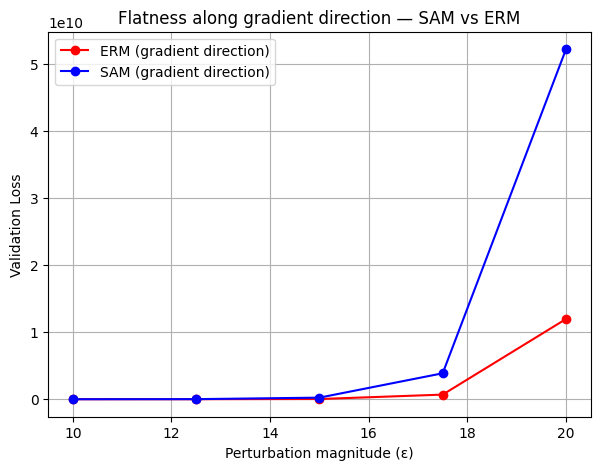

In [52]:
criterion = nn.CrossEntropyLoss()
epsilons = torch.linspace(10, 20, 5).tolist()  # adjust range if needed

erm_losses = gradient_direction_perturbation(erm_model, small_train_loader, criterion, epsilons, device)
sam_losses = gradient_direction_perturbation(sam_model, small_train_loader, criterion, epsilons, device)

plt.figure(figsize=(7,5))
plt.plot(epsilons, erm_losses, 'r-o', label='ERM (gradient direction)')
plt.plot(epsilons, sam_losses, 'b-o', label='SAM (gradient direction)')
plt.xlabel("Perturbation magnitude (ε)")
plt.ylabel("Validation Loss")
plt.title("Flatness along gradient direction — SAM vs ERM")
plt.legend()
plt.grid(True)
plt.show()